# 2024 Spoken Wiki attentional word recognition task results

### Analysis is for main diotic experiment
### Models run on all combinations of stimuli
___

In [ ]:
import pickle
import numpy as np 
import re 
from pathlib import Path
import pandas as pd
import json
import pickle
import importlib 
import IPython.display as ipd
%matplotlib inline 

import matplotlib.pyplot as plt 
import seaborn as sns

import src.util_process_prolific as up 
from src import util_analysis
from tqdm import tqdm
importlib.reload(up)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42







### Import human data

In [2]:
path_to_human_data = Path('/mindhive/mcdermott/www/imgriff/msjspsych/')
path_to_expmt_stim = Path("/om/user/imgriff/datasets/human_word_rec_SWC_2024/")
# !ls {path_to_human_data}
# full paths to .json files 
human_fnames = list(path_to_human_data.glob("cocktail_party_word_recognition_all_conds/data/*.json"))

len(human_fnames)

428

## Process Human Results

In [3]:
## Get all subject data into one df for analysis

dfs = []
for fname in human_fnames:
    try:
        dfs.append(up.get_part_df_swc(fname))
    except Exception as e:
        print(e)
        print(fname)
    
# results_df = pd.concat([get_part_df(fname) for fname in human_fnames], axis=0, ignore_index=True)
results_df = pd.concat(dfs)

## Filter for those who passed headphone check 
results_df = results_df[results_df.hc_passed == True]
## Filter self reported hearing loss 
results_df = results_df[results_df.hearing_loss == False]
# results_df = results_df[results_df.over_ear_hf == True]

## Add snr and condition names as columns - unpack from file code in file names 

# get cond name map
map_path = path_to_expmt_stim / 'human_attn_expmt_cond_map.pkl' 
with open(map_path, 'rb') as handle:
    stim_cond_map = pickle.load(handle)
stim_cond_map = {f"condition_{k:02}": v for k,v in stim_cond_map.items()}

# add as columns 
results_df['snr'], results_df['condition'] = zip(*results_df['stimulus'].apply(lambda x: up.get_stim_snr_and_cond(x, stim_cond_map=stim_cond_map)))

# cut down df to only have trial answers (remove other meta data)
expmnt_trial_str = "dictionary-text"
trial_results = results_df[results_df.trial_type == expmnt_trial_str].copy()
trial_results.rename(columns={"condition":"raw_condition"}, inplace=True)

# Convert condition names to  readable format 
test_condition_dict = {'music':"background_musdb18hq",
                       "babble":"background_cv08talkerbabble",
                       "stationary": "background_issnstationary",
                       "natural scene": "background_ieeeaaspcasa",
                       "clean": "SILENCE"}
# 1-talker conds preserved in replace below

condition_map = {v:k for k,v in test_condition_dict.items()}
trial_results['condition'] = trial_results['raw_condition'].replace(condition_map)

# screen based on completion 
total_trials = 196
full_run_subjects = [subj_id for subj_id, did_all_trials in (trial_results.groupby('id_subject').condition.count() == total_trials).items() if did_all_trials == True]
trial_results = trial_results[trial_results.id_subject.isin(full_run_subjects)]
# Add accuracy 
trial_results['accuracy'] = (trial_results['response'] == trial_results['correct_response']).astype('int')

# add shortened stim name field 
trial_results['stim_name'] = trial_results['stimulus'].str.split('/').str[-1].str.split('.').str[0]

# drop coluns in trial_results that are all nans 
trial_results = trial_results.dropna(axis=1, how='all')

Unterminated string starting at: line 1 column 84194 (char 84193)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_6658b1491e88ec15902d5301.json
Unterminated string starting at: line 1 column 192613 (char 192612)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_6174b049932ee98236563b51.json
Unterminated string starting at: line 1 column 72207 (char 72206)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_65dc99d0191a135ab835bf69.json
Unterminated string starting at: line 1 column 324626 (char 324625)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_5c0430c71a20110001e9b05a.json
Expecting ',' delimiter: line 1 column 204794 (char 204793)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_word_recognition_all_conds/data/subj_666883e7cd549b6798159085.json
Unterminated string starting at: line 1 column 60213

In [4]:
# catch_trial_particiapnt_performance
catch_trial_particiapnt_performance = trial_results[trial_results.condition == 'catch_trial'].groupby('id_subject').accuracy.mean()

print("N total participants ", len(catch_trial_particiapnt_performance))
good_participants = catch_trial_particiapnt_performance[catch_trial_particiapnt_performance >= 11/12].index
print("N good participants ", len(good_participants))

good_results = trial_results[trial_results.id_subject.isin(good_participants)]
analysis_df = good_results[(~good_results.condition.isnull()) & (~good_results.response.isna())]
analysis_df = analysis_df.dropna(axis=1, how='all').dropna(axis=0, how='all')
# analysis_df.groupby('id_subject').condition.count()

N total participants  208
N good participants  195



#### Add re-scored performance based on entries included in excerpt transcripts  

In [5]:
### Make map from cv dictionary ixs to experiment word ixs 

## import cv maps
import pickle
cv_word_2_class = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
cv_class_2_word = {v:k for k,v in cv_word_2_class.items()}


## import experiment word map
human_exp_word_key = pickle.load( open(path_to_expmt_stim / "human_attn_expmt_word_key.pkl", "rb" )) 
exp_word_2_class = {v:k for k,v in human_exp_word_key.items()}



### Manage in-transcript rescoring

In [6]:
## Will add columns 'base_str', 'target_gender', 'target_f0', 'distractor_f0', 'distractor_gender' from manifests to trial_results where trial_results.stimulus == manifests.base_str

manifests = pd.read_pickle(path_to_expmt_stim / "human_cue_target_distractor_df_w_meta_transcripts_w_f0.pdpkl")
# add columns for word int and stim name to map back to participant data 
manifests['word_fname_int'] = manifests['word'].replace(exp_word_2_class)
manifests['stim_name'] = manifests[['gender', 'word_fname_int']].apply(lambda row: f"{row.gender[0]}_{row.word_fname_int:03d}", axis=1)

cols_to_merge = ['stim_name',
                 'gender',
                 'word',
                 'target_f0',
                 'english_distractor_f0',
                 'mandarin_distractor_f0',
                 'dutch_distractor_f0',
                 'target_transcripts',
                 'same_sex_distractor_1_transcripts',
                 'diff_sex_distractor_1_transcripts',
                 "same_sex_dist_1_word",
                 "diff_sex_dist_1_word"
]

analysis_df = pd.merge(analysis_df,
                        manifests[cols_to_merge],
                                    left_on='stim_name', right_on='stim_name', how='left')
analysis_df['confusions'] = (analysis_df.response == analysis_df.same_sex_dist_1_word).astype('int')
analysis_df['accuracy'] = (analysis_df.response == analysis_df.word).astype('int')


# add adjusted accuracy and confusions 
pred_words = analysis_df.response.values
target_words = analysis_df.word.values
target_transcripts = analysis_df.target_transcripts.values
same_sex_distractor_words = analysis_df.same_sex_dist_1_word.values
diff_sex_distractor_words = analysis_df.diff_sex_dist_1_word.values
same_sex_distractor_transcripts = analysis_df.same_sex_distractor_1_transcripts.values
diff_sex_distractor_transcripts = analysis_df.diff_sex_distractor_1_transcripts.values


adjusted_acc = np.array([int(pred_word in target_transcript or pred_word == target_word)
                            if not isinstance(target_transcript, float) else np.nan
                            for pred_word, target_word, target_transcript in zip(pred_words, target_words, target_transcripts)
                            ])

adjusted_confs = np.array([int(pred_word in same_sex_transcript or pred_word in diff_sex_transcript or pred_word == same_sex_word or pred_word == diff_sex_word)
                            if not (isinstance(same_sex_transcript, float) and isinstance(diff_sex_transcript, float)) else np.nan
                            for pred_word, same_sex_word, diff_sex_word, same_sex_transcript, diff_sex_transcript in zip(pred_words, same_sex_distractor_words, diff_sex_distractor_words,  same_sex_distractor_transcripts, diff_sex_distractor_transcripts)
                            ])

analysis_df['adjusted_accuracy'] = adjusted_acc
analysis_df['adjusted_confusions'] = adjusted_confs

## Remap 1-talker distractor names accordingly 

analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'sex_cond'] = analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'condition'].str.split('-').str[-1].str.title()
analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'dist_lang'] = analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'condition'].str.split('-').str[-2].str.title()

def remap_1_distractor_str(cond_str):
    if 'english' in cond_str:
        return '1-talker'
    if 'mandarin' in cond_str:
        return "Mandarin distractor"
    if 'dutch' in cond_str:
        return "Dutch distractor"

analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'condition'] = analysis_df.loc[analysis_df.condition.str.contains('1-talker'), 'condition'].apply(remap_1_distractor_str)
analysis_df = analysis_df[~analysis_df.condition.isin(['catch_trial', "Dutch distractor"])]



/tmp/ipykernel_2666134/3084302696.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  manifests['word_fname_int'] = manifests['word'].replace(exp_word_2_class)


In [7]:
analysis_df.condition.unique()

array(['stationary', 'Mandarin distractor', 'natural scene', 'clean',
       '1-talker', 'babble', '2-talker', '4-talker', 'music'],
      dtype=object)

In [8]:
to_check = analysis_df[analysis_df.condition!="catch_trial"]
(to_check.adjusted_accuracy >= to_check.accuracy).all()

True

In [9]:
analysis_df.condition.unique()

array(['stationary', 'Mandarin distractor', 'natural scene', 'clean',
       '1-talker', 'babble', '2-talker', '4-talker', 'music'],
      dtype=object)

In [10]:
##########################
# Make df for f0 analysis 
##########################

# drop unwanted conditions
f0_analysis_df = analysis_df[analysis_df.condition.isin([ "1-talker", 'Mandarin distractor', 'clean'])].copy()

# cut and remove language-specific f0 columns - just make distractor f0 
f0_analysis_df.loc[f0_analysis_df.dist_lang == 'English', 'distractor_f0'] = f0_analysis_df.loc[f0_analysis_df.dist_lang == 'English', 'english_distractor_f0'].values
f0_analysis_df.loc[f0_analysis_df.dist_lang == 'Mandarin', 'distractor_f0'] = f0_analysis_df.loc[f0_analysis_df.dist_lang == 'Mandarin', 'mandarin_distractor_f0'].values
# f0_analysis_df.loc[f0_analysis_df.dist_lang == 'Dutch', 'distractor_f0'] = f0_analysis_df.loc[f0_analysis_df.dist_lang == 'Dutch', 'dutch_distractor_f0'].values

f0_analysis_df["abs_f0_diff"] = np.abs(f0_analysis_df.target_f0 - f0_analysis_df.distractor_f0)
f0_analysis_df["percent_f0_diff"] = f0_analysis_df.distractor_f0 / f0_analysis_df.target_f0 
def get_f0_ratio(row):
    return max(row.target_f0, row.distractor_f0) / min(row.target_f0, row.distractor_f0)
f0_analysis_df["f0_ratio"] = f0_analysis_df.apply(get_f0_ratio, axis=1)

# # rename condition to background condition
f0_analysis_df = f0_analysis_df.rename(columns={"condition": "background_condition"})
f0_analysis_df = f0_analysis_df.dropna(axis=1,  how = 'all')
# get columns with trial in their name
cols_to_drop = [col for col in f0_analysis_df.columns if 'trial' in col ]
# drop prolific meta columns
f0_analysis_df = f0_analysis_df.drop(columns=cols_to_drop).reset_index(drop=True)


In [11]:
# get trial data excluding catch trials 


part_summary_df = (analysis_df.groupby(["snr", 'id_subject', "condition"])
                     .agg({'correct':['mean', 'count'],
                            'confusions':['mean'],
                            'adjusted_accuracy':['mean'],
                            'adjusted_confusions':['mean']})
                     .reset_index())

part_summary_df['snr'] = part_summary_df['snr'].replace(np.inf, 6)
part_summary_df['snr'] =  part_summary_df['snr'].replace("inf", 6)
part_summary_df['snr'] = part_summary_df['snr'].astype('int')
# flatten multiindex 
part_summary_df.columns = ['_'.join(col).strip() for col in part_summary_df.columns.values]
# remove trailing underscore
part_summary_df.columns = [col[:-1] if col.endswith('_') else col for col in part_summary_df.columns.values]


/tmp/ipykernel_2666134/1142350907.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  part_summary_df['snr'] =  part_summary_df['snr'].replace("inf", 6)


In [12]:
## Summarize participant data for aggregate plotting

summary_df = part_summary_df.groupby(['snr', 'condition']).agg({'correct_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem', 'count'],
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
summary_df.columns = ['snr', 'background_condition', 'accuracy', 'acc_std_error', 'confusions', 'conf_std_error', 'N', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error']


## Load Model Results 

In [13]:
## import class maps
import pickle
cv_word_2_class = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
cv_class_2_word = {v:k for k,v in cv_word_2_class.items()}

### Get conditions 
cond_map = pickle.load( open(path_to_expmt_stim / "human_attn_expmt_cond_map.pkl", "rb" )) 
conds = set([cond for cond,snr in cond_map.values()])

test_cond_to_human = {v:k for k,v in test_condition_dict.items()}
cond_remap = {}
for cond in conds:
    if cond in test_cond_to_human:
        cond_remap[cond] = test_cond_to_human[cond]
    else:
        cond_remap[cond] = cond 
cond_remap['natural scene'] = 'natural scene'


In [14]:
cond_remap

{'1-talker-english-different': '1-talker-english-different',
 '4-talker': '4-talker',
 '1-talker-dutch-different': '1-talker-dutch-different',
 'SILENCE': 'clean',
 '1-talker-mandarin-different': '1-talker-mandarin-different',
 'background_issnstationary': 'stationary',
 '1-talker-mandarin-same': '1-talker-mandarin-same',
 '2-talker': '2-talker',
 'background_ieeeaaspcasa': 'natural scene',
 '1-talker-english-same': '1-talker-english-same',
 'background_musdb18hq': 'music',
 'background_cv08talkerbabble': 'babble',
 '1-talker-dutch-same': '1-talker-dutch-same',
 'natural scene': 'natural scene'}

In [15]:

model_names = [
    # "word_task_half_co_loc_v10_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout",
                # "word_task_v08_control_no_attn",
                "word_task_v10_control_no_attn",
                "word_task_early_only_v10",
                "word_task_late_only_v10",
                # "word_task_half_co_loc_v09_50Hz_cutoff",
                "word_task_v10_main_feature_gain_config",
                # "word_task_v10_backbone_word_config",
                # "word_task_v10_backbone_word_config_no_gains"
                # "word_task_conventional_layer_order"
                ]# "word_task_half_co_loc_v08_gender_bal_4M_w_no_cue_learned"]
             
arch_search_models = [path.stem for path in Path('swc_2024_eval_full_stim/').glob('*v10*arch_*')]
model_names.extend(arch_search_models)


model_name_dict = {
                #    'word_task_v08_control_no_attn': 'Baseline CNN',
                   'word_task_v10_control_no_attn': 'Baseline CNN',
                   'word_task_early_only_v10': 'Early-only',
                   'word_task_late_only_v10': 'Late-only',
                #    'word_task_half_co_loc_v09_50Hz_cutoff': '50Hz cutoff',
                   "word_task_v10_main_feature_gain_config": 'Feature-gain Model',
                #    "word_task_v10_backbone_word_config": 'Computed-gain model',
                #    "word_task_v10_backbone_word_config_no_gains": "Backbone no gains"

                  }

all_model_results = []
all_model_f0_results = []

background_conditions = summary_df.background_condition.unique() 
str_to_cond = {v:k for k,v in test_condition_dict.items()}

## preselect manifest columns 
cols_to_merge = [
                #  'stim_name',
                 'gender',
                 'word',
                 'word_int',
                 'target_f0',
                 'english_distractor_f0',
                 'mandarin_distractor_f0',
                 'dutch_distractor_f0',
                 'target_transcripts',
                 'same_sex_distractor_1_transcripts',
                 'diff_sex_distractor_1_transcripts',
                 "same_sex_dist_1_word",
                 "diff_sex_dist_1_word"

]

manifests['word_int'] = manifests.word.replace(cv_word_2_class)
model_manifest = manifests[cols_to_merge].sort_values(['gender', 'word']).copy()
model_manifest['df_index'] = model_manifest.index

# update gt manifests to match readable format 
for model_name in model_names:
    print(model_name)
    output_paths = list(Path(f'swc_2024_eval_full_stim/{model_name}').glob('*.csv'))
    print(len(output_paths))
    results_dfs = []
    try:

        for path in output_paths:
            # print(path)
            try:
                df = pd.read_csv(path)
                # reformat dict
                df['model'] = path.parent.name
                #parts of name 
                parts = path.stem.split(path.parent.name)[-1].split('_')   
                # if 'stim_tag' in df.columns:
                #     # rename 
                #     df.rename(columns={'stim_tag':'stim_name'}, inplace=True)
                # use re to split path.stem after model name and before <int>dB 
                df['background_condition'] = [v for v in cond_remap.values() if "_".join(v.split(' ')) in path.stem][0]
                if 'clean' in path.stem:
                    df['background_condition'] = 'clean'
                    df['snr'] =  'inf' # really np.inf, 6 for plotting 
                else:
                    df['snr'] = int(re.search('(-?\d+)dB', path.stem).group(0).strip('dB'))

                df['test_index'] = df.index
                df = pd.merge(df,
                    model_manifest,
                                left_on=["test_index", "true_word_int"], right_on=["df_index", "word_int"])

                if 'dutch' in df['background_condition'].unique()[0]:
                    continue
                results_dfs.append(df)
            except Exception as e:
                # print(e)
                continue
    

        model_results = pd.concat(results_dfs, axis=0, ignore_index=True)
        # if model_name in model_name_dict:
        #     model_str = model_name_dict[model_name]
        # else:
        #     model_str = model_name
        model_results['group'] = util_analysis.get_model_name(model_name)
        ## Load in model vocab 
        model_results['pred_word'] = model_results['pred_word_int'].replace(cv_class_2_word)
        model_results['true_word'] = model_results['true_word_int'].replace(cv_class_2_word)


        # Add 1-talker condition metadata to model results

        # add confusions 
        model_results['confusions'] = (model_results.pred_word == model_results.same_sex_dist_1_word).astype('int')

        # add adjusted accuracy and confusions 
        pred_words = model_results.pred_word.values
        target_words = model_results.word.values
        target_transcripts = model_results.target_transcripts.values
        same_sex_distractor_words = model_results.same_sex_dist_1_word.values
        diff_sex_distractor_words = model_results.same_sex_dist_1_word.values
        same_sex_distractor_transcripts = model_results.same_sex_distractor_1_transcripts.values
        diff_sex_distractor_transcripts = model_results.diff_sex_distractor_1_transcripts.values


        adjusted_acc = np.array([int(pred_word in target_transcript or pred_word == target_word)
                                    if not isinstance(target_transcript, float) else np.nan
                                    for pred_word, target_word, target_transcript in zip(pred_words, target_words, target_transcripts)
                                    ])

        adjusted_confs = np.array([int(pred_word in same_sex_transcript or pred_word in diff_sex_transcript or pred_word == same_sex_word or pred_word == diff_sex_word)
                                    if not (isinstance(same_sex_transcript, float) and isinstance(diff_sex_transcript, float)) else np.nan
                                    for pred_word, same_sex_word, diff_sex_word, same_sex_transcript, diff_sex_transcript in zip(pred_words, same_sex_distractor_words, diff_sex_distractor_words,  same_sex_distractor_transcripts, diff_sex_distractor_transcripts)
                                    ])
        
        model_results['adjusted_accuracy'] = adjusted_acc
        model_results['adjusted_confusions'] = adjusted_confs
        model_results.loc[model_results.background_condition.str.contains('1-talker'), 'sex_cond'] = model_results.loc[model_results.background_condition.str.contains('1-talker'), 'background_condition'].str.split('-').str[-1].str.title()
        model_results.loc[model_results.background_condition.str.contains('1-talker'), 'dist_lang'] = model_results.loc[model_results.background_condition.str.contains('1-talker'), 'background_condition'].str.split('-').str[-2].str.title()
        model_results.loc[model_results.background_condition.str.contains('1-talker'), 'background_condition'] = model_results.loc[model_results.background_condition.str.contains('1-talker'), 'background_condition'].apply(remap_1_distractor_str)

        
        all_model_results.append(model_results)


        model_f0_df = model_results[model_results.background_condition.isin([ "1-talker", 'Mandarin distractor', 'clean'])].copy()
        model_f0_df.loc[model_f0_df.dist_lang == 'English', 'distractor_f0'] = model_f0_df.loc[model_f0_df.dist_lang == 'English', 'english_distractor_f0'].values
        model_f0_df.loc[model_f0_df.dist_lang == 'Mandarin', 'distractor_f0'] = model_f0_df.loc[model_f0_df.dist_lang == 'Mandarin', 'mandarin_distractor_f0'].values
        # model_f0_df.loc[model_f0_df.dist_lang == 'Dutch', 'distractor_f0'] = model_f0_df.loc[model_f0_df.dist_lang == 'Dutch', 'dutch_distractor_f0'].values
        model_f0_df["abs_f0_diff"] = np.abs(model_f0_df.target_f0 - model_f0_df.distractor_f0)
        model_f0_df["percent_f0_diff"] = model_f0_df.distractor_f0 / model_f0_df.target_f0 
        model_f0_df["f0_ratio"] = model_f0_df.apply(get_f0_ratio, axis=1)
        model_f0_df.loc[:, "abs_f0_diff"] = np.abs(model_f0_df.target_f0 - model_f0_df.distractor_f0)
        model_f0_df.loc[:, "percent_f0_diff"] = model_f0_df.distractor_f0 / model_f0_df.target_f0 
        all_model_f0_results.append(model_f0_df)
    except Exception as e:
        print(e)
        print(model_name)
        continue
all_model_results = pd.concat(all_model_results, axis=0, ignore_index=True)
all_model_f0_results = pd.concat(all_model_f0_results, axis=0, ignore_index=True)

/tmp/ipykernel_2666134/2541617826.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  manifests['word_int'] = manifests.word.replace(cv_word_2_class)


word_task_v10_control_no_attn
61
word_task_early_only_v10
61
word_task_late_only_v10
61
word_task_v10_main_feature_gain_config
61
word_task_v10_4MGB_ln_first_arch_1
61
word_task_v10_4MGB_ln_first_arch_10
61
word_task_v10_4MGB_ln_first_arch_12
61
word_task_v10_4MGB_ln_first_arch_2
61
word_task_v10_4MGB_ln_first_arch_4
61
word_task_v10_4MGB_ln_first_arch_6
61
word_task_v10_4MGB_ln_first_arch_7
61
word_task_v10_4MGB_ln_first_arch_8
61
word_task_v10_4MGB_ln_first_arch_9
61


In [16]:
all_model_results.model.value_counts()

model
word_task_v10_control_no_attn             49776
word_task_early_only_v10                  49776
word_task_late_only_v10                   49776
word_task_v10_main_feature_gain_config    49776
word_task_v10_4MGB_ln_first_arch_1        49776
word_task_v10_4MGB_ln_first_arch_10       49776
word_task_v10_4MGB_ln_first_arch_12       49776
word_task_v10_4MGB_ln_first_arch_2        49776
word_task_v10_4MGB_ln_first_arch_4        49776
word_task_v10_4MGB_ln_first_arch_6        49776
word_task_v10_4MGB_ln_first_arch_7        49776
word_task_v10_4MGB_ln_first_arch_8        49776
word_task_v10_4MGB_ln_first_arch_9        49776
Name: count, dtype: int64

In [17]:
all_model_results.loc[all_model_results.model == 'word_task_v10_backbone_word_config_no_gains', 'group'] = 'Backbone no gains'
all_model_f0_results.loc[all_model_f0_results.model == 'word_task_v10_backbone_word_config_no_gains', 'group'] = 'Backbone no gains'
all_model_results.group.value_counts()

group
Baseline CNN            49776
Early-only              49776
Late-only               49776
Feature-gain main       49776
Feature-gain alt v1     49776
Feature-gain alt v10    49776
Feature-gain alt v12    49776
Feature-gain alt v2     49776
Feature-gain alt v4     49776
Feature-gain alt v6     49776
Feature-gain alt v7     49776
Feature-gain alt v8     49776
Feature-gain alt v9     49776
Name: count, dtype: int64

In [18]:
# all_model_f0_results.loc[all_model_f0_results.model == 'word_task_v10_backbone_word_config_no_gains', 'group'] = 'Backbone no gains'
all_model_f0_results.group.value_counts()

group
Baseline CNN            20496
Early-only              20496
Late-only               20496
Feature-gain main       20496
Feature-gain alt v1     20496
Feature-gain alt v10    20496
Feature-gain alt v12    20496
Feature-gain alt v2     20496
Feature-gain alt v4     20496
Feature-gain alt v6     20496
Feature-gain alt v7     20496
Feature-gain alt v8     20496
Feature-gain alt v9     20496
Name: count, dtype: int64

## Summarize data for analysis and plotting

In [19]:
# Adjusted accuracy should always greater than or equal to accuracy
(all_model_results['adjusted_accuracy'] >= all_model_results['accuracy']).all() 

True

### Summarize main experiment

In [20]:
N = int(summary_df.N.unique().item())

summary_df['group'] = f'Humans (N={N})'
# model_results['group'] = model_results['group']
# all_model_results = all_model_results[all_model_results.snr > -12]
# combine model and participant results ignore missing columns
combined_results = pd.concat([summary_df, all_model_results], axis=0, ignore_index=True)

combined_results.loc[combined_results.snr == np.inf, 'snr'] = 6
combined_results.loc[combined_results.snr == 'inf', 'snr'] = 6
combined_results.snr = combined_results.snr.astype('int')

combined_results['background_condition'].rename({"stationary":"noise"}, inplace=True)
# combined_results = combined_results[combined_results.snr > -12]
combined_results.loc[combined_results.background_condition == "stationary", 'background_condition'] = "noise"
combined_results.loc[combined_results.group.str.contains('Human'), 'model'] = combined_results.loc[combined_results.group.str.contains('Human'), 'group'] 


In [21]:
combined_results.model.value_counts()

model
word_task_v10_control_no_attn             49776
word_task_early_only_v10                  49776
word_task_late_only_v10                   49776
word_task_v10_main_feature_gain_config    49776
word_task_v10_4MGB_ln_first_arch_1        49776
word_task_v10_4MGB_ln_first_arch_10       49776
word_task_v10_4MGB_ln_first_arch_12       49776
word_task_v10_4MGB_ln_first_arch_2        49776
word_task_v10_4MGB_ln_first_arch_4        49776
word_task_v10_4MGB_ln_first_arch_6        49776
word_task_v10_4MGB_ln_first_arch_7        49776
word_task_v10_4MGB_ln_first_arch_8        49776
word_task_v10_4MGB_ln_first_arch_9        49776
Humans (N=195)                               41
Name: count, dtype: int64

### Summarize distractor sex results

In [33]:
np.random.seed(0)
#################################
# Summarize humans 
################################# 
f0_to_analyze = f0_analysis_df.copy()
f0_to_analyze['group'] =  f'Humans (N={N})'
f0_to_analyze.loc[f0_to_analyze.snr == 'inf', 'sex_cond'] = 'clean'
f0_to_analyze.loc[f0_to_analyze.snr == 'inf', 'dist_lang'] = 'clean'
f0_to_analyze.reset_index(inplace=True, drop=True)
human_dist_df = (f0_to_analyze.groupby(["snr", "id_subject", "sex_cond", "dist_lang"])
                     .agg({
                            'adjusted_accuracy':['mean'],
                            'adjusted_confusions':['mean']})
                     .reset_index())

human_dist_df['snr'] = human_dist_df['snr'].replace(np.inf, 6)
human_dist_df['snr'] =  human_dist_df['snr'].replace("inf", 6)
human_dist_df['snr'] = human_dist_df['snr'].astype('int')
# flatten multiindex 
human_dist_df.columns = ['_'.join(col).strip() for col in human_dist_df.columns.values]
# remove trailing underscore
human_dist_df.columns = [col[:-1] if col.endswith('_') else col for col in human_dist_df.columns.values]

# human summary

### Human distractor sex summary 
summary_sex_cond_df = human_dist_df.groupby(['snr', 'sex_cond']).agg({
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
summary_sex_cond_df.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']

# Get human sex confusions - only english 
summary_sex_confusions = human_dist_df[human_dist_df.dist_lang == 'English'].groupby(['snr', 'sex_cond']).agg({
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
summary_sex_confusions.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']

# update confusions in summary df 
summary_sex_cond_df[['confusions', 'conf_sem']] = summary_sex_confusions[['confusions', 'conf_sem']]

### Human distractor language summary 
summary_dist_lang_df = human_dist_df.groupby(['snr', 'dist_lang']).agg({
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
summary_dist_lang_df.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']
N = int(f0_to_analyze.id_subject.nunique())
summary_sex_cond_df['group'] = f'Humans (N={N})'
summary_dist_lang_df['group'] = f'Humans (N={N})'
human_sex_lang_summary = pd.concat([summary_sex_cond_df, summary_dist_lang_df], axis=0, ignore_index=True)
human_sex_lang_summary['model']  = human_sex_lang_summary['group']

human_sex_lang_summary = human_sex_lang_summary.loc[human_sex_lang_summary.background_condition != 'clean'].reset_index(drop=True)

#################################
# Setup summary for models  
################################# 
all_model_f0_results_to_analyze = all_model_f0_results.copy()
all_model_f0_results_to_analyze['id_subject'] = all_model_f0_results_to_analyze['group']
all_model_f0_results_to_analyze.loc[all_model_f0_results_to_analyze.snr == 'inf', 'sex_cond'] = 'clean'
all_model_f0_results_to_analyze.loc[all_model_f0_results_to_analyze.snr == 'inf', 'dist_lang'] = 'clean'

model_f0_summary = (all_model_f0_results_to_analyze.groupby(["snr", "model", "sex_cond", "dist_lang"])
                     .agg({
                            'adjusted_accuracy':['mean'],
                            'adjusted_confusions':['mean']})
                     .reset_index())
model_f0_summary['snr'] = model_f0_summary['snr'].replace(np.inf, 6)
model_f0_summary['snr'] =  model_f0_summary['snr'].replace("inf", 6)
model_f0_summary['snr'] = model_f0_summary['snr'].astype('int')
# flatten multiindex 
model_f0_summary.columns = ['_'.join(col).strip() for col in model_f0_summary.columns.values]
# remove trailing underscore
model_f0_summary.columns = [col[:-1] if col.endswith('_') else col for col in model_f0_summary.columns.values]

#################################
# Summarize fba models  
#################################  

# get individual fba model summaries
fba_model_f0_df = model_f0_summary[model_f0_summary.model.str.contains('main|arch_')].copy()

# fba sex summary - average over architectures
fba_total_summary_sex_cond_df = fba_model_f0_df.groupby(['snr', 'sex_cond']).agg({
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
fba_total_summary_sex_cond_df.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']

# handle confusions 
fba_total_sex_confusions = fba_model_f0_df[fba_model_f0_df.dist_lang == 'English'].groupby(['snr', 'sex_cond']).agg({
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
fba_total_sex_confusions.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']

# update confusions in summary df 
fba_total_summary_sex_cond_df[['confusions', 'conf_sem']] = fba_total_sex_confusions[['confusions', 'conf_sem']]

### fba distractor language summary 
fba_total_summary_dist_lang_df = fba_model_f0_df.groupby(['snr', 'dist_lang']).agg({
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
fba_total_summary_dist_lang_df.columns =  ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']

fba_total_summary_sex_cond_df['group'] = 'Feature-gain Model'
fba_total_summary_dist_lang_df['group'] = 'Feature-gain Model'

fba_totaL_sex_lang_summary = pd.concat([fba_total_summary_sex_cond_df, fba_total_summary_dist_lang_df], axis=0, ignore_index=True).drop_duplicates()
fba_totaL_sex_lang_summary = fba_totaL_sex_lang_summary.loc[fba_totaL_sex_lang_summary.background_condition != 'clean'].reset_index(drop=True)

# get individual fba model summaries 
# fba sex summary 
fba_model_summary_sex_cond_df = fba_model_f0_df.groupby(['model', 'snr', 'sex_cond']).agg({
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
fba_model_summary_sex_cond_df.columns = ['model', 'snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']

# handle confusions 
for (model, snr, sex_cond), _ in fba_model_f0_df[fba_model_f0_df.dist_lang == 'English'].groupby(['model', 'snr', 'sex_cond']):
       if sex_cond == 'clean':
              continue
       else:
              data = all_model_f0_results_to_analyze[(all_model_f0_results_to_analyze.model == model)
                                                        & (all_model_f0_results_to_analyze.snr == snr)
                                                        & (all_model_f0_results_to_analyze.sex_cond == sex_cond)]
              accs = data.adjusted_accuracy.values
              acc_sem = util_analysis.bootstrap_sem(accs)
              group = data.group.values[0]

              # get confusions
              confs = data[data.dist_lang == 'English'].adjusted_confusions.values     
              conf_sem = util_analysis.bootstrap_sem(confs)

              ix = (fba_model_summary_sex_cond_df.model == model) & (fba_model_summary_sex_cond_df.snr == snr) & (fba_model_summary_sex_cond_df.background_condition == sex_cond)
              fba_model_summary_sex_cond_df.loc[ix, 'accuracy'] = accs.mean()
              fba_model_summary_sex_cond_df.loc[ix, 'acc_sem'] = acc_sem
              fba_model_summary_sex_cond_df.loc[ix, 'confusions'] = confs.mean()
              fba_model_summary_sex_cond_df.loc[ix, 'conf_sem'] = conf_sem


### fba distractor language summary 
fba_model_summary_dist_lang_df = fba_model_f0_df.groupby(['model', 'snr', 'dist_lang']).agg({
                                                             'adjusted_accuracy_mean':['mean','sem'], 'adjusted_confusions_mean':['mean', 'sem']}).reset_index()
fba_model_summary_dist_lang_df.columns =  ['model', 'snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']

for (model, snr, dist_lang), _ in fba_model_f0_df.groupby(['model', 'snr','dist_lang']):
       if dist_lang == 'clean':
              continue 
       else:
            data = all_model_f0_results_to_analyze[(all_model_f0_results_to_analyze.model == model)
                                                    & (all_model_f0_results_to_analyze.snr == snr)
                                                    & (all_model_f0_results_to_analyze.dist_lang == dist_lang)]
            accs = data.adjusted_accuracy.values
            confs = data.adjusted_confusions.values
            acc_sem = util_analysis.bootstrap_sem(accs)
            conf_sem = util_analysis.bootstrap_sem(confs)
            group = data.group.values[0]

            ix = (fba_model_summary_dist_lang_df.model == model) & (fba_model_summary_dist_lang_df.snr == snr) & (fba_model_summary_dist_lang_df.background_condition == dist_lang)
            fba_model_summary_dist_lang_df.loc[ix, 'accuracy'] = accs.mean()
            fba_model_summary_dist_lang_df.loc[ix, 'acc_sem'] = acc_sem
            fba_model_summary_dist_lang_df.loc[ix, 'confusions'] = confs.mean()
            fba_model_summary_dist_lang_df.loc[ix, 'conf_sem'] = conf_sem


fba_model_summary_sex_cond_df['group'] = 'Feature-gain Model'
fba_model_summary_dist_lang_df['group'] = 'Feature-gain Model'
fba_model_sex_lang_summary = pd.concat([fba_model_summary_sex_cond_df, fba_model_summary_dist_lang_df], axis=0, ignore_index=True).drop_duplicates()

# drop clean condition - is duplicate of main experiment 
fba_model_sex_lang_summary = fba_model_sex_lang_summary.loc[fba_model_sex_lang_summary.background_condition != 'clean'].reset_index(drop=True)

############################
# Summarize control models
############################
control_model_f0_df = model_f0_summary[~model_f0_summary.model.str.contains('main|arch_')].copy()
control_sex_summary = []
for (model, snr, sex_cond), _ in control_model_f0_df.groupby(['model', 'snr', 'sex_cond']):
       if sex_cond == 'clean':
              continue
       else:
              data = all_model_f0_results_to_analyze[(all_model_f0_results_to_analyze.model == model)
                                                        & (all_model_f0_results_to_analyze.snr == snr)
                                                        & (all_model_f0_results_to_analyze.sex_cond == sex_cond)]
              accs = data.adjusted_accuracy.values
              acc_sem = util_analysis.bootstrap_sem(accs)
              group = data.group.values[0]

              # get confusions
              confs = data[data.dist_lang == 'English'].adjusted_confusions.values     
              conf_sem = util_analysis.bootstrap_sem(confs)

              control_sex_summary.append(
                                   {'group':group, 'model':model, 'snr': snr, "background_condition":sex_cond, 
                                   'accuracy': accs.mean(), 'acc_sem': acc_sem,
                                   'confusions': confs.mean(), 'conf_sem': conf_sem}
                     )

control_sex_summary_df = pd.DataFrame(control_sex_summary)

control_lang_summary = []
for (model, snr, dist_lang), _ in control_model_f0_df.groupby(['model', 'snr','dist_lang']):
       if dist_lang == 'clean':
              continue 

       else:
              data = all_model_f0_results_to_analyze[(all_model_f0_results_to_analyze.model == model)
                                                        & (all_model_f0_results_to_analyze.snr == snr)
                                                        & (all_model_f0_results_to_analyze.dist_lang == dist_lang)]
              accs = data.adjusted_accuracy.values
              confs = data.adjusted_confusions.values
              acc_sem = util_analysis.bootstrap_sem(accs)
              conf_sem = util_analysis.bootstrap_sem(confs)
              group = data.group.values[0]

              control_lang_summary.append(
                                   {'group':group, 'model':model, 'snr': snr, "background_condition":dist_lang,
                                   'accuracy': accs.mean(), 'acc_sem': acc_sem,
                                   'confusions': confs.mean(), 'conf_sem': conf_sem}
                     )

control_lang_summary_df = pd.DataFrame(control_lang_summary)
control_sex_lang_summary = pd.concat([control_sex_summary_df, control_lang_summary_df], axis=0, ignore_index=True).drop_duplicates()


/tmp/ipykernel_2666134/3740082548.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  human_dist_df['snr'] =  human_dist_df['snr'].replace("inf", 6)
/tmp/ipykernel_2666134/3740082548.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_f0_summary['snr'] =  model_f0_summary['snr'].replace("inf", 6)


In [34]:
fba_model_summary_dist_lang_df

,model,snr,background_condition,accuracy,acc_sem,confusions,conf_sem,group
0,word_task_v10_4MGB_ln_first_arch_1,-9,English,0.203893,0.009243,0.241291,0.009947,Feature-gain Model
1,word_task_v10_4MGB_ln_first_arch_1,-9,Mandarin,0.317111,0.010241,0.005635,0.001708,Feature-gain Model
2,word_task_v10_4MGB_ln_first_arch_1,-6,English,0.293033,0.010500,0.168033,0.008862,Feature-gain Model
3,word_task_v10_4MGB_ln_first_arch_1,-6,Mandarin,0.420082,0.011317,0.005635,0.001665,Feature-gain Model
4,word_task_v10_4MGB_ln_first_arch_1,-3,English,0.389344,0.010933,0.113217,0.007033,Feature-gain Model
...,...,...,...,...,...,...,...,...
105,word_task_v10_main_feature_gain_config,0,English,0.534836,0.011150,0.093750,0.006463,Feature-gain Model
106,word_task_v10_main_feature_gain_config,0,Mandarin,0.638832,0.010464,0.001025,0.000713,Feature-gain Model
107,word_task_v10_main_feature_gain_config,3,English,0.616291,0.011241,0.059939,0.005306,Feature-gain Model
108,word_task_v10_main_feature_gain_config,3,Mandarin,0.699283,0.010620,0.001537,0.000860,Feature-gain Model


In [35]:
##########################
# set common column names 
##########################
full_df_col_names = ['model', 'snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem', 'N']
summary_df_col_names = ['group', 'snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem', 'N']

# screen language results - will use what we summarized above
combined_results = combined_results[~combined_results.background_condition.str.contains('Mandarin|Dutch')]

##########################
# Get human data summary
##########################
human_summary = combined_results[combined_results.group.str.contains('Human')].copy()
human_summary = human_summary[['group', 'snr', 'background_condition', 'adjusted_accuracy', 'adj_acc_std_error', 'adjusted_confusions', 'adj_conf_std_error', 'N']]
# human_summary['model'] = human_summary['group']
human_summary.columns = summary_df_col_names
human_summary = pd.concat([human_summary, human_sex_lang_summary], axis=0, ignore_index=True).drop_duplicates()
human_summary['group'] = f"Human (N={N})"
human_summary['model']  = human_summary['group']

# make human_part level summary 
part_summary_to_keep = part_summary_df[['snr', 'id_subject', 'condition', 'adjusted_accuracy_mean', 'adjusted_confusions_mean']]
part_summary_to_keep.columns = ['snr', 'id_subject', 'background_condition', 'accuracy', 'confusions']
# participant_level_sumary = pd.concat([part_summary_to_keep, human_part_level_sex_lang_summary], axis=0, ignore_index=True)

#################################
# Get feature-gain model summary
#################################
fba_data = combined_results[combined_results.group.str.contains('Feature')].copy()
fba_model_summary = fba_data.groupby(['model', 'snr', 'background_condition']).agg({'adjusted_accuracy':['mean', 'sem'], 'adjusted_confusions':['mean', 'sem', 'count']}).reset_index()
fba_model_summary.columns = full_df_col_names
# combine with sex and language result

fba_total_summary = fba_model_summary.groupby(['snr', 'background_condition']).agg({'accuracy':['mean', 'sem'], 'confusions':['mean', 'sem', 'count']}).reset_index()
fba_total_summary.columns = summary_df_col_names[1:]
fba_total_summary['group'] = 'Feature-gain Model'
fba_total_summary = fba_total_summary[summary_df_col_names]
# combine with sex and language result
fba_model_summary = pd.concat([fba_model_summary, fba_model_sex_lang_summary], axis=0, ignore_index=True).drop_duplicates()
fba_model_summary['group'] = 'Feature-gain Model'

fba_total_summary = pd.concat([fba_total_summary, fba_totaL_sex_lang_summary], axis=0, ignore_index=True).drop_duplicates()

#############################
# Get control model summary
#############################
control_list = 'Baseline|Early|Late|50Hz|Computed|Backbone|Saddler'

control_models = combined_results[combined_results.group.str.contains(control_list)].copy()
control_summary = []
for (model, snr, condition), group in control_models.groupby(['model', 'snr', 'background_condition']):
    accs = group.adjusted_accuracy.values
    confs = group.adjusted_confusions.values
    acc_sem = util_analysis.bootstrap_sem(accs)
    conf_sem = util_analysis.bootstrap_sem(confs)
    group = group.group.values[0]
    control_summary.append(
                            {'group':group, 'model':model, 'snr': snr, 'background_condition': condition, 
                             'accuracy': accs.mean(), 'acc_sem': acc_sem,
                             'confusions': confs.mean(), 'conf_sem': conf_sem, 'N':1}
              )
control_summary = pd.DataFrame(control_summary)
# merge and drop duplicate clean row from distractor language analysis 
control_summary = pd.concat([control_summary, control_sex_lang_summary], axis=0, ignore_index=True).drop_duplicates()

In [36]:

## Should give 56 per model (36 main conditions + 20 sex and language conditions)
fba_model_summary.model.value_counts()


model
word_task_v10_4MGB_ln_first_arch_1        56
word_task_v10_4MGB_ln_first_arch_10       56
word_task_v10_4MGB_ln_first_arch_12       56
word_task_v10_4MGB_ln_first_arch_2        56
word_task_v10_4MGB_ln_first_arch_4        56
word_task_v10_4MGB_ln_first_arch_6        56
word_task_v10_4MGB_ln_first_arch_7        56
word_task_v10_4MGB_ln_first_arch_8        56
word_task_v10_4MGB_ln_first_arch_9        56
word_task_v10_main_feature_gain_config    56
Name: count, dtype: int64

In [37]:
control_summary.model.value_counts()

model
word_task_early_only_v10         56
word_task_late_only_v10          56
word_task_v10_control_no_attn    56
Name: count, dtype: int64

In [38]:
### Set up plot df 
human_summary['model'] = human_summary['group']
# fba_total_summary['model'] = fba_total_summary['group']
all_combined = pd.concat([human_summary, fba_model_summary, control_summary], axis=0, ignore_index=True)
df_to_plot = pd.concat([human_summary, fba_total_summary, control_summary], axis=0, ignore_index=True)
df_to_plot['snr'] = df_to_plot['snr'].astype('int')
all_combined['snr'] = all_combined['snr'].astype('int')
all_combined['model'] = all_combined['model'].astype('str')

In [39]:
all_combined.model.value_counts()

model
Human (N=195)                             56
word_task_v10_4MGB_ln_first_arch_1        56
word_task_v10_4MGB_ln_first_arch_10       56
word_task_v10_4MGB_ln_first_arch_12       56
word_task_v10_4MGB_ln_first_arch_2        56
word_task_v10_4MGB_ln_first_arch_4        56
word_task_v10_4MGB_ln_first_arch_6        56
word_task_v10_4MGB_ln_first_arch_7        56
word_task_v10_4MGB_ln_first_arch_8        56
word_task_v10_4MGB_ln_first_arch_9        56
word_task_v10_main_feature_gain_config    56
word_task_early_only_v10                  56
word_task_late_only_v10                   56
word_task_v10_control_no_attn             56
Name: count, dtype: int64

In [40]:
all_combined.group.value_counts()

group
Feature-gain Model    560
Human (N=195)          56
Early-only             56
Late-only              56
Baseline CNN           56
Name: count, dtype: int64

In [41]:
# model_conds = model_results.snr_condition_str.unique()

human_conds = all_combined[all_combined.model.str.contains('Human')].copy()
human_conds['cond_str'] = human_conds['background_condition'] + ' ' + human_conds['snr'].astype('str') + 'dB'
human_cond_str = human_conds.cond_str.unique()


for model in all_combined[~all_combined.model.str.contains('Human')].model.unique():
    model_conds = all_combined[all_combined.model == model].copy()
    model_conds['cond_str'] = model_conds['background_condition'] + ' ' + model_conds['snr'].astype('str') + 'dB'
    model_cond_str = model_conds.cond_str.unique()
    missing_conds = human_cond_str[~np.isin(human_cond_str, model_cond_str)]
    if len(missing_conds) > 0:
        print(model, missing_conds)

In [42]:
all_combined.model.value_counts() ## Should return 56 for each model

model
Human (N=195)                             56
word_task_v10_4MGB_ln_first_arch_1        56
word_task_v10_4MGB_ln_first_arch_10       56
word_task_v10_4MGB_ln_first_arch_12       56
word_task_v10_4MGB_ln_first_arch_2        56
word_task_v10_4MGB_ln_first_arch_4        56
word_task_v10_4MGB_ln_first_arch_6        56
word_task_v10_4MGB_ln_first_arch_7        56
word_task_v10_4MGB_ln_first_arch_8        56
word_task_v10_4MGB_ln_first_arch_9        56
word_task_v10_main_feature_gain_config    56
word_task_early_only_v10                  56
word_task_late_only_v10                   56
word_task_v10_control_no_attn             56
Name: count, dtype: int64

In [43]:
out_dir = Path('final_results_dir')
# out_name = out_dir / f"df_for_stats_and_summary_2024_SWC_diotic_conditions_humans_N-195_models_v10_w_control_50Hz_ECDF_models.pdpkl"

out_name = out_dir / f"experiment_1_df.pdpkl"

all_combined.to_pickle(out_name)

## Standard analysis 

##### Look at all models individually

## Plot summary of feature gain vs alternates

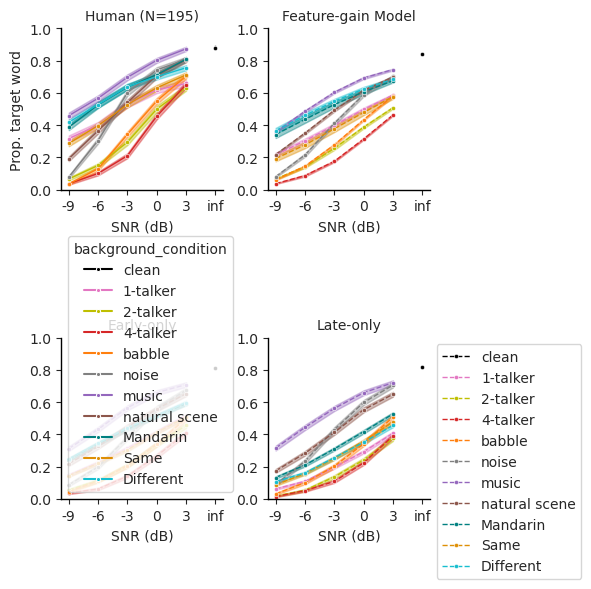

In [45]:
# df_to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
# df_to_plot = combined_results[(~combined_results.background_condition.isin(["catch_trial", 'audioset']))  ] # & ~(combined_results.group == 'Baseline CNN')
sns.set_style('ticks')



# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'noise',  'music', 'natural scene',  'Mandarin', "Same", "Different"]
palette={}
palette['clean'] = 'k'
palette['1-talker'] = 'tab:pink'
palette['2-talker'] = 'y'
palette['babble'] = 'tab:orange'
palette['4-talker'] = 'tab:red'
palette['noise'] = 'grey'
palette['music'] = 'tab:purple'
palette['natural scene'] = 'tab:brown'
palette['Mandarin'] = 'teal'

sex_order = ['Different', 'Same', 'clean']

sex_pal = dict(zip(sex_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Different'] = 'tab:cyan'
palette['Same'] = sex_pal['Same']

fontsize=10
tick_fontsize = 10
# fontsize = 10

models = df_to_plot.group.unique()

aspect = 3
sem_order = 1 
n_models = len(models)//2
n_rows = 2
n_cols = n_models 

fig, axs = plt.subplots(n_rows, n_cols, figsize=((aspect) * n_cols , aspect * n_rows))
axs = axs.flatten()
err_band_alpha = 0.4
# add markers to relplot
models = [f'Human (N={N})', 'Feature-gain Model', 'Early-only', 'Late-only', 'Baseline CNN', '50Hz cutoff', "Computed-gain model", "Backbone no gains"]
x_tick_locs = df_to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, models):
    sns.lineplot(data=df_to_plot[df_to_plot.group == model],  x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                #   errorbar=('se', 2), err_style='band',
                #     err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = df_to_plot[df_to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        error = selected['acc_sem'].values * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'].values, selected['accuracy'].values - error,
                         selected['accuracy'].values + error, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
for ix in range(n_models):
    axs[ix].legend().remove()
for ix in range(1,len(axs)):
    axs[ix].set_ylabel("", fontsize=fontsize)

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)

# move axs[1] legend 
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)


# set space between pannels 
# plt.subplots_adjust(wspace=0.25)
# 
plt.tight_layout()
# plt.savefig(outfig_dest/'human_v_model_acc_for_poster.pdf', transparent=True, bbox_inches='tight')

# adjust w space 

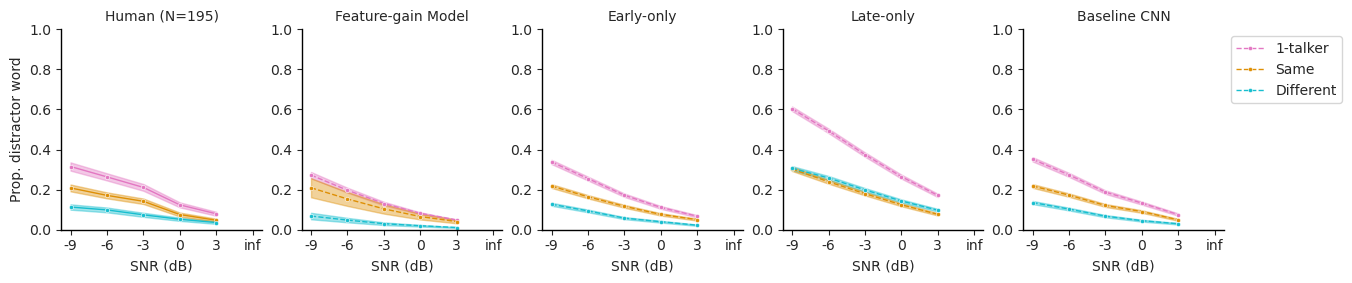

In [46]:
# df_to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
sns.set_style('ticks')

# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['1-talker', "Same", "Different"]

# palette['Mandarin distractor'] = 'teal'

fontsize=10
tick_fontsize = 10
# fontsize = 10

models = df_to_plot.group.unique()

aspect = 3
sem_order = 1 
n_models = len(models)
n_rows = 1
n_cols = n_models 

fig, axs = plt.subplots(n_rows, n_cols, figsize=((aspect) * n_cols , aspect * n_rows))
axs = axs.flatten()
err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', ]
x_tick_locs = df_to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

models = [f'Human (N={N})', 'Feature-gain Model', 'Early-only', 'Late-only', 'Baseline CNN', '50Hz cutoff', 'Computed-gain model']

for ax, model in zip(axs, models):
    ax.plot(x_tick_locs, np.ones(len(x_tick_locs)) * 0.5, 'w', alpha=0.5, label=None)
    data = df_to_plot[df_to_plot['group'].eq(model)]
    sns.lineplot(data=data,  x='snr', y='confusions', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                  errorbar=None,# err_style='band', err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        error = selected['conf_sem'] * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'], selected['confusions'] - error,
                         selected['confusions'] + error, color=palette[group], alpha=err_band_alpha)

            
    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()

for ix in range(n_models-1):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. distractor word", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)

# set space between pannels 
# plt.subplots_adjust(wspace=0.25)

# plt.tight_layout()
# plt.savefig(outfig_dest/'human_v_model_conf_english_for_poster.pdf', transparent=True, bbox_inches='tight')

# adjust w space 

/tmp/ipykernel_3480181/649320260.py:53: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_to_plot[df_to_plot.group == model],  x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
/tmp/ipykernel_3480181/649320260.py:53: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_to_plot[df_to_plot.group == model],  x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


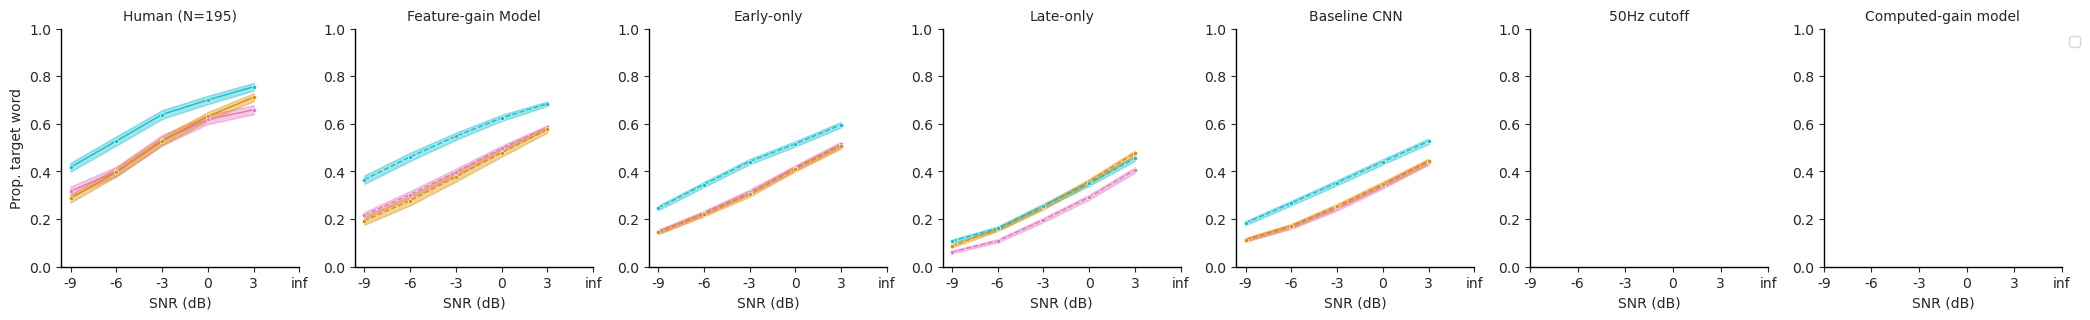

In [47]:
# df_to_plot = combined[(combined.condition!='audioset') & (combined.snr > -12)]
# df_to_plot = combined_results[(~combined_results.background_condition.isin(["catch_trial", 'audioset']))  ] # & ~(combined_results.group == 'Baseline CNN')
sns.set_style('ticks')



# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['1-talker', "Same", "Different"]
palette={}
palette['clean'] = 'k'
palette['1-talker'] = 'tab:pink'
palette['2-talker'] = 'y'
palette['babble'] = 'tab:orange'
palette['4-talker'] = 'tab:red'
palette['noise'] = 'grey'
palette['music'] = 'tab:purple'
palette['natural scene'] = 'tab:brown'
palette['Mandarin'] = 'teal'

sex_order = ['Different', 'Same', 'clean']

sex_pal = dict(zip(sex_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Different'] = 'tab:cyan'
palette['Same'] = sex_pal['Same']

fontsize=10
tick_fontsize = 10
# fontsize = 10

# models = df_to_plot.group.unique()
models = [f'Human (N={N})', 'Feature-gain Model', 'Early-only', 'Late-only', 'Baseline CNN', '50Hz cutoff', 'Computed-gain model']

aspect = 3
sem_order = 1 
n_models = len(models)
n_rows = 1
n_cols = n_models 

fig, axs = plt.subplots(n_rows, n_cols, figsize=((aspect) * n_cols , aspect * n_rows))
axs = axs.flatten()
err_band_alpha = 0.4
# add markers to relplot
# models = [f'Humans (N={N})', 'Feature-gain Model', ]
x_tick_locs = df_to_plot.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, models):
    sns.lineplot(data=df_to_plot[df_to_plot.group == model],  x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                #   errorbar=('se', 2), err_style='band',
                #     err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = df_to_plot[df_to_plot['group'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        error = selected['acc_sem'].values * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'].values, selected['accuracy'].values - error,
                         selected['accuracy'].values + error, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(model, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
# g._legend.remove()
sns.despine()
for ix in range(n_models-1):
    axs[ix].legend().remove()
for ix in range(1,len(axs)):
    axs[ix].set_ylabel("", fontsize=fontsize)

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)

# move axs[1] legend 
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)


# set space between pannels 
# plt.subplots_adjust(wspace=0.25)
# 
plt.tight_layout()
# plt.savefig(outfig_dest/'human_v_model_acc_for_poster.pdf', transparent=True, bbox_inches='tight')

# adjust w space 

In [ ]:
### Run stats on human results 
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm


to_anova = participant_level_sumary[participant_level_sumary.background_condition.isin(["Same", "Different"])].copy()

aov = AnovaRM(to_anova, depvar='confusions', subject='id_subject',
    within=["snr", "background_condition"]).fit()
print(aov)

                         Anova
                         F Value Num DF  Den DF  Pr > F
-------------------------------------------------------
snr                      51.7079 4.0000 776.0000 0.0000
background_condition     89.1077 1.0000 194.0000 0.0000
snr:background_condition  7.8389 4.0000 776.0000 0.0000



In [ ]:
from pingouin import rm_anova
to_anova = participant_level_sumary[participant_level_sumary.background_condition.isin(["Same", "Different"])].copy()


human_rm_anova_table = rm_anova(data=to_anova, dv='confusions', subject='id_subject', within=["snr", "background_condition"], effsize='np2')
print("ANOVA for humans")
human_rm_anova_table

ANOVA for humans


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,snr,14.739316,4,776,3.684829,51.707947,1.263796e-38,3.715776e-35,0.210445,0.903461
1,background_condition,6.037051,1,194,6.037051,89.107739,1.205725e-17,1.205725e-17,0.314749,1.000000
2,snr * background_condition,1.940798,4,776,0.485199,7.838925,3.397410e-06,6.459883e-06,0.038838,0.933941


In [112]:
combined_results.group.unique().shape

(14,)

### All architectures 

In [113]:
combined_results.model.unique()

array(['Humans (N=195)', 'word_task_v10_control_no_attn',
       'word_task_early_only_v10', 'word_task_late_only_v10',
       'word_task_v10_main_feature_gain_config',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9'], dtype=object)

In [114]:
import re 

def get_model_str(model):
    if 'early' in model:
        return 'Early-only'
    elif 'late' in model:
        return 'Late-only'
    elif 'control' in model:
        return 'Baseline CNN'
    elif '50Hz' in model:
        return '50Hz cutoff'
    elif 'main' in model:
        return 'Feature-gain Model'
    elif 'arch' in model:
        version_int = re.search(r'arch_(\d+)', model).group(1)
        return f'Feature-gain alt v{version_int}'
    else:
        return model

In [115]:
models

['Human (N=195)',
 'Feature-gain Model',
 'Early-only',
 'Late-only',
 'Baseline CNN',
 '50Hz cutoff',
 'Computed-gain model']

In [116]:
all_models

NameError: name 'all_models' is not defined

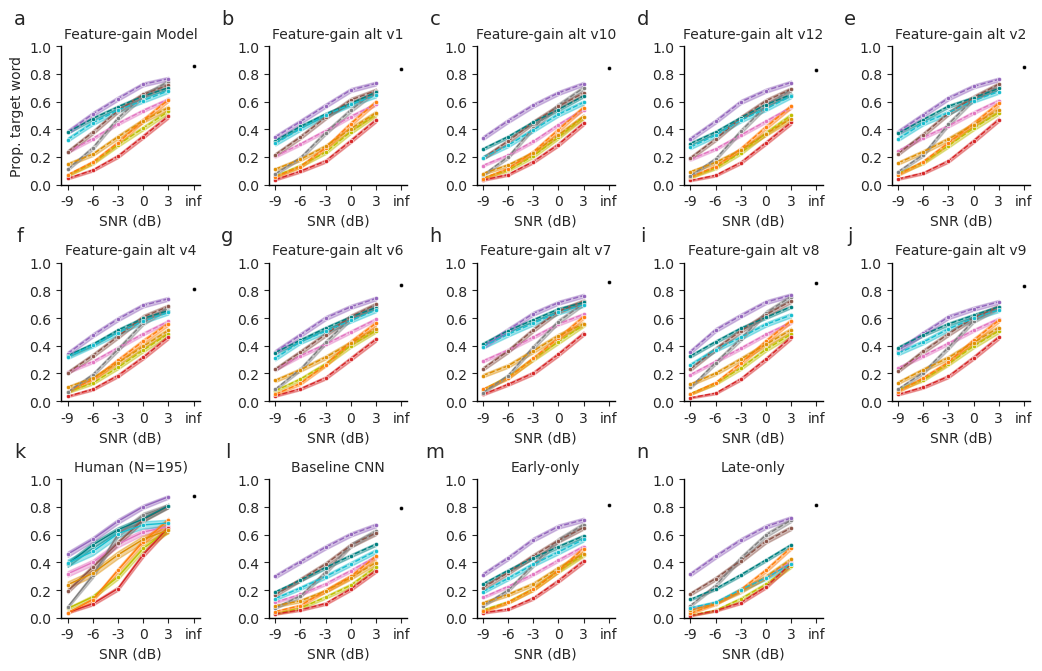

In [117]:
# all_combined = combined[(combined.condition!='audioset') & (combined.snr > -12)]
# all_combined = combined_results[(~combined_results.background_condition.isin(["catch_trial", 'audioset']))  ] # & ~(combined_results.group == 'Baseline CNN')
sns.set_style('ticks')



# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'noise',  'music', 'natural scene',  'Mandarin', "Same", "Different"]
palette={}
palette['clean'] = 'k'
palette['1-talker'] = 'tab:pink'
palette['2-talker'] = 'y'
palette['babble'] = 'tab:orange'
palette['4-talker'] = 'tab:red'
palette['noise'] = 'grey'
palette['music'] = 'tab:purple'
palette['natural scene'] = 'tab:brown'
palette['Mandarin'] = 'teal'

sex_order = ['Different', 'Same', 'clean']

sex_pal = dict(zip(sex_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Different'] = 'tab:cyan'
palette['Same'] = sex_pal['Same']

fontsize=10
tick_fontsize = 10
# fontsize = 10

all_models = all_combined.model.unique()


err_band_alpha = 0.4
# add markers to relplot
model_order = [f'Human (N={N})',
                'word_task_v10_control_no_attn',
                'word_task_early_only_v10', 
                'word_task_late_only_v10',
                # 'word_task_half_co_loc_v09_50Hz_cutoff'
                ]
also_sort = [m for m in all_models if m not in model_order and '50Hz' not in m and 'main' not in m and 'backbone' not in m]
feature_gain_models = ['word_task_v10_main_feature_gain_config'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))
model_order = feature_gain_models + model_order 


aspect = 2.5
sem_order = 1 
n_models = len(model_order)
n_cols = 5 #(n_models // n_rows)
n_rows = int(np.ceil(n_models / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=((aspect) * n_cols , aspect * n_rows))
axs = axs.flatten()


x_tick_locs = all_combined.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, model_order):
    sns.lineplot(data=all_combined[all_combined.model == model],
                 x='snr', y='accuracy', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                #   errorbar=('se', 2), err_style='band',
                #     err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = all_combined[all_combined['model'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        error = selected['acc_sem'].values * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'].values, selected['accuracy'].values - error,
                         selected['accuracy'].values + error, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(get_model_str(model), fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
sns.despine()
for ix in range(n_models):
    if ix == 0:
        handles, labels = axs[0].get_legend_handles_labels()
    axs[ix].legend().remove()
for ix in range(1,len(axs)):
    axs[ix].set_ylabel("", fontsize=fontsize)
for ix in range(len(axs)):
    if ix > n_models - 1:
        axs[ix].set_visible(False)

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)

# add panel lettering to top left of each pannel
for ix, ax in enumerate(axs):
    if ix < n_models:
        ax.text(-0.3, 1.2, f'{chr(97+ix)}', transform=ax.transAxes, fontsize=fontsize+4, va='center', ha='center')


# adjust space between pannels
plt.subplots_adjust(wspace=0.5, hspace=0.5)
# plt.tight_layout()

# adjust w space 

IndexError: index 6 is out of bounds for axis 0 with size 6

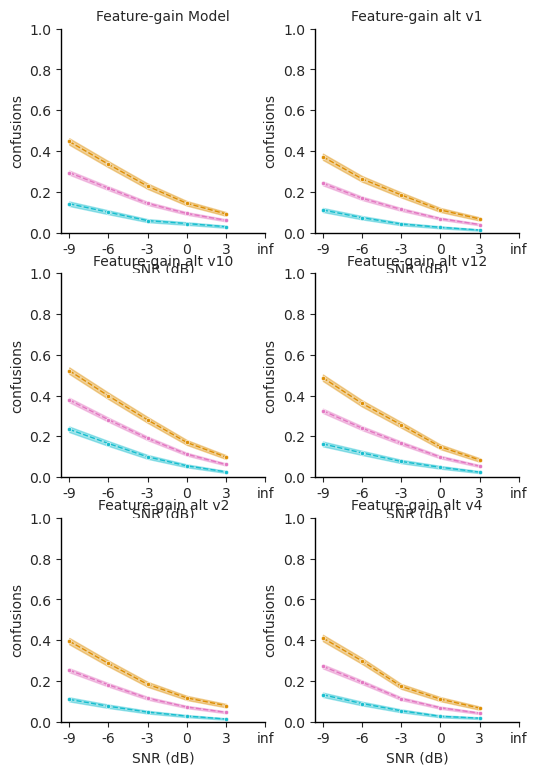

In [118]:
# all_combined = combined[(combined.condition!='audioset') & (combined.snr > -12)]
# all_combined = combined_results[(~combined_results.background_condition.isin(["catch_trial", 'audioset']))  ] # & ~(combined_results.group == 'Baseline CNN')
sns.set_style('ticks')



# hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble',  'Dutch distractor', 'Mandarin distractor', 'noise', 'music', 'natural scene']
hue_order = ['1-talker', "Same", "Different"]
palette={}
palette['clean'] = 'k'
palette['1-talker'] = 'tab:pink'
palette['2-talker'] = 'y'
palette['babble'] = 'tab:orange'
palette['4-talker'] = 'tab:red'
palette['noise'] = 'grey'
palette['music'] = 'tab:purple'
palette['natural scene'] = 'tab:brown'
palette['Mandarin'] = 'teal'

sex_order = ['Different', 'Same', 'clean']

sex_pal = dict(zip(sex_order[:-1], sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Different'] = 'tab:cyan'
palette['Same'] = sex_pal['Same']

fontsize=10
tick_fontsize = 10
# fontsize = 10

all_models = all_combined.model.unique()

aspect = 3
sem_order = 1 
n_models = len(models)
n_rows = 3
n_cols = (n_models // n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=((aspect) * n_cols , aspect * n_rows))
axs = axs.flatten()
err_band_alpha = 0.4
# add markers to relplot
model_order = [f'Human (N={N})',
                'word_task_early_only_v10', 
                'word_task_late_only_v10',
                'word_task_v10_control_no_attn',
                # 'word_task_half_co_loc_v09_50Hz_cutoff'
                ]
also_sort = [m for m in all_models if m not in model_order]
feature_gain_models = ['word_task_v10_main_feature_gain_config'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))
model_order = feature_gain_models + model_order 

x_tick_locs = all_combined.snr.unique()
x_tick_labels = [str(x) for x in x_tick_locs]
x_tick_labels[-1] = 'inf'

yticks = np.linspace(0,1,6).round(1)
ratio = 1.0 
line_thickness = 1

for ax, model in zip(axs, model_order):
    sns.lineplot(data=all_combined[all_combined.model == model],
                 x='snr', y='confusions', hue='background_condition', hue_order=hue_order,
                  palette=palette, ax=ax,
                #   errorbar=('se', 2), err_style='band',
                #     err_kws={'alpha':err_band_alpha},
                  marker='.', 
                 )
    data = all_combined[all_combined['model'].eq(model)]
    # select the data for each hue group
    for group, selected in data.groupby('background_condition'):
        if not group in hue_order:
            continue
        # plot the errorbar with the correct color for each group 
        error = selected['conf_sem'].values * sem_order
        # add errorbar as fill_between 
        ax.fill_between(selected['snr'].values, selected['confusions'].values - error,
                         selected['confusions'].values + error, color=palette[group], alpha=err_band_alpha)

    ax.set_xlabel("SNR (dB)", fontsize=fontsize)
    ax.set_title(get_model_str(model), fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != models[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')

# remove legend
sns.despine()
for ix in range(n_models):
    if ix == 0:
        handles, labels = axs[0].get_legend_handles_labels()
    axs[ix].legend().remove()
for ix in range(1,len(axs)):
    axs[ix].set_ylabel("", fontsize=fontsize)
for ix in range(len(axs)):
    if ix > n_models - 1:
        axs[ix].set_visible(False)

axs[0].set_ylabel("Prop. target word", fontsize=fontsize)

# get handles from first pannel

# add to pannel 9
# axs[9].legend(handles=handles, labels=labels, loc='center right', bbox_to_anchor=(1,1), fontsize=fontsize)

# legend = axs[15].legend([axs[15].plot([],[])[0] for _ in   labels], labels,

plt.tight_layout()
# plt.savefig(outfig_dest/'human_v_model_acc_for_poster.pdf', transparent=True, bbox_inches='tight')

# adjust w space 